# Import libraries

In [30]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import random
import os

# v0.2 imports
import mplfinance as fplt
import matplotlib.pyplot as plt

# v0.4 imports
import time
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, RNN, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [31]:
# set seed to get stable results in training/testing run
np.random.seed(314)
# tf.random.set_seed(314)
random.seed(314)

In [32]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, TEST_START='2020-01-01', TEST_END='2023-01-01', n_steps=50, scale=True, shuffle=True, lookup_step=1, dropNaN=True, split_by_date=True, test_size=0.2, feature_columns=["adjclose", "volume", "open", "high", "low"]):
    """
    Loads data from yahoo finance, then scaling, shuffle, and normalization.
    :param ticker: (str/pd.DataFrame), the ticker you want to load, like META, AAPL,...
    :param TEST_START: str, the start date of the test data (format: "YYYY-MM-DD")
    :param TEST_END: str, the end date of the test data (format: "YYYY-MM-DD")
    :param n_steps: int, the historical sequence length (i.e window size) use to predict, default is 50
    :param scale: whether to scale prices between 0 and 1, default is True
    :param shuffle: bool, whether to shuffle the dataset (both training and testing), default is True
    :param lookup_step: int, the future lookup step to predict, default is 1 (e.g next day)
    :param dropNaN: bool, whether to drop NaN values, default is True
    :param split_by_date: bool, whether to split the data into training and testing by date, default is True
    :param test_size: ratio of test data to train data, default is 0.2 (20% test data)
    :param feature_columns: the list of features to feed into the model, default is everything grabbed from yahoo_fin
    :return: 
    """
    
    # ------------------------------------------------------------------------------------------------#
    # Ticket to csv file, put it into folder dataset
    ticker_data_filename = os.path.join("dataset", f"{ticker}_{TEST_START}_{TEST_END}.csv") 
    ## a, see if ticker is already a loaded stock from yahoo finance
    if os.path.exists(ticker_data_filename):
        print(f'Loading data from {ticker_data_filename}')
        # read csv file, take date column as index
        df = pd.read_csv(ticker_data_filename, index_col=0)
    else:
        print(f'Downloading data for {ticker} from yahoo finance')
        if not os.path.exists("dataset"):
            os.makedirs("dataset")
        # download data from yahoo finance before assign into dataframe
        df = si.get_data(ticker, TEST_START, TEST_END)
         ## d, Store the download data locally for future use
        df.to_csv(ticker_data_filename)
    # ------------------------------------------------------------------------------------------------#






    # ------------------------------------------------------------------------------------------------#
    ## b, Allow you to deal with the NaN issue in the data
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)

    # last `lookup_step` column contains NaN in the future column
    # get them before droping Nans
    last_sequence = np.array(df[feature_columns].tail(lookup_step))

    # drop NaNs or fill nan with median
    if dropNaN:
        df.dropna(inplace=True)
    else:
        df.fillna(df.mean())
    # ------------------------------------------------------------------------------------------------#




    # this will contain all the elements we want to return from this function
    result = {}

    # we will also return the original dataframe itself
    result['df'] = df.copy()




    # ------------------------------------------------------------------------------------------------#
    ## c, use different methods to split the data into train/test data; 
    # e.g. you can split it according to some specified ratio of train/test and you can specify to split it by date or randomly
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df['date'] = df.index

    # this will be the length of the sequences that we will use to predict future stock prices
    sequence_data = []
    # restrict the sequence maximum step that can be taken
    sequences = deque(maxlen=n_steps)
    # add the entry to the sequences, then check the sequence length before store target value into sequence_data
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence 
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset.
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    
    # Construct the X's and y's
    X, y = [], []
    # iterate over the sequences and append to X and y
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        # :train_samples means from the beginning to train_samples, and train_samples: means from train_samples to the end
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"] = X[train_samples:]
        result["y_test"] = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    # ------------------------------------------------------------------------------------------------#



   
    # ------------------------------------------------------------------------------------------------#
    ## e, scale the feature columns and store the scalers in data structure 
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # ------------------------------------------------------------------------------------------------#

    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    
    return result

In [33]:
# Amazon stock market
TICKER = "AMZN"

# Start and End date to read:
TEST_START = '2020-01-01'
TEST_END = '2023-01-01'

# Window size or the sequence length
N_STEPS = 50

# whether to scale feature columns & output price as well
SCALE = True

# lookup step, 1 is the next day
LOOKUP_STEP = 15

# drop rows with NaN values
DROP_NAN = True

# whether to shuffle the dataset
SHUFFLE = True

# whether to split the training/testing set by date
SPLIT_BY_DATE = False

# test radio size, 0.2 is 20%
TEST_SIZE = 0.2

# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]

In [34]:
data = load_data(ticker=TICKER, TEST_START=TEST_START, TEST_END=TEST_END, n_steps=N_STEPS, scale=SCALE, lookup_step=LOOKUP_STEP, dropNaN=DROP_NAN,
          shuffle=SHUFFLE, split_by_date=SPLIT_BY_DATE, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

Loading data from dataset/AMZN_2020-01-01_2023-01-01.csv


In [35]:
data["df"].head()

,open,high,low,close,adjclose,volume,ticker,future
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,AMZN,93.082001
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,AMZN,91.417000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,AMZN,92.662498
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,AMZN,92.900002
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000,AMZN,93.533997


# Improve to v0.2: Include charts

In [36]:
def display_stock_candlestick(data, n=1, title='Candlestick chart'):
    """
    Write a function to display stock market financial data using candlestick chart
    :param data: pd.DataFrame, stock market data with columns ['Open', 'High', 'Low', 'Close', 'Volume']
    :param n: trading days
    :param title: show the chart title
    :return: 
    """
    # check if index column is datetime
    if not isinstance(data.index, pd.DataFrame):
        data.index = pd.to_datetime(data.index)
    
    # allow each candle stick to express the data of `n` trading days
    if n >= 1:
        # Resample the data to aggregate over 'n' trading days
        data = data.resample(f'{n}D').agg({
            'open' : 'first',
            'high' : 'max',
            'low' : 'min',
            'close' : 'last',
            'volume' : 'sum'
        }).dropna()

    # plot the candlestick chart
    fplt.plot(
        data,
        type='candle',
        style='charles',
        title=title,
        ylabel='Price ($)',
        volume=True,
        ylabel_lower='Shares\nTraded'
    )


/opt/miniconda3/envs/OptionBStkPredictPrice/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


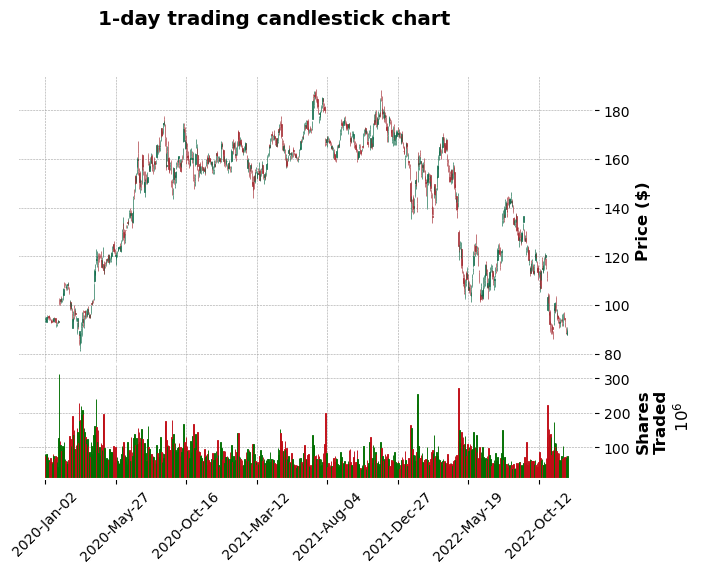

In [37]:
display_stock_candlestick(data["df"], n=1, title='1-day trading candlestick chart')

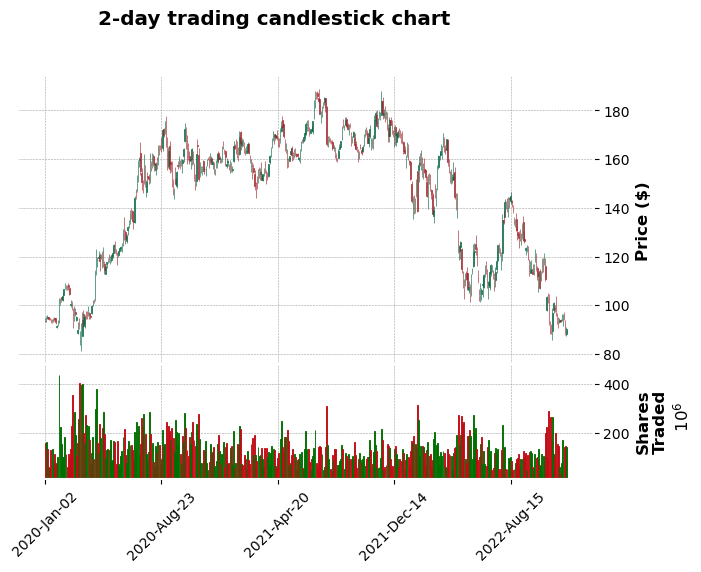

In [38]:
display_stock_candlestick(data["df"], n=2, title='2-day trading candlestick chart')

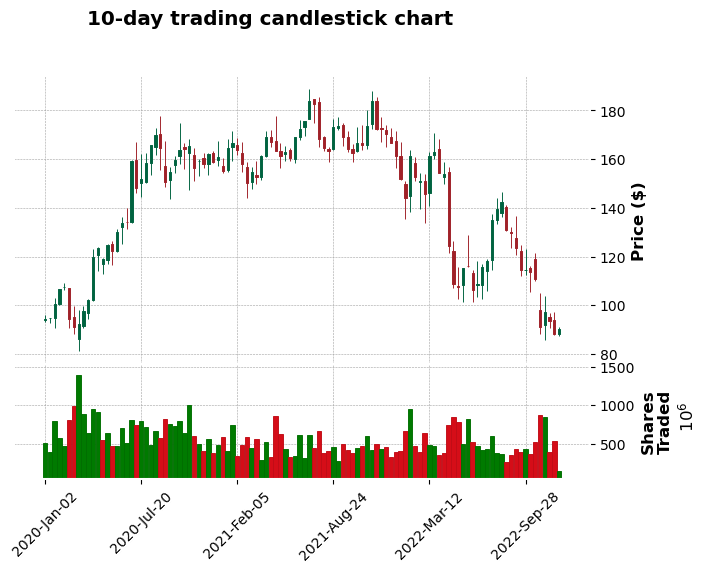

In [39]:
display_stock_candlestick(data["df"], n=10, title='10-day trading candlestick chart')

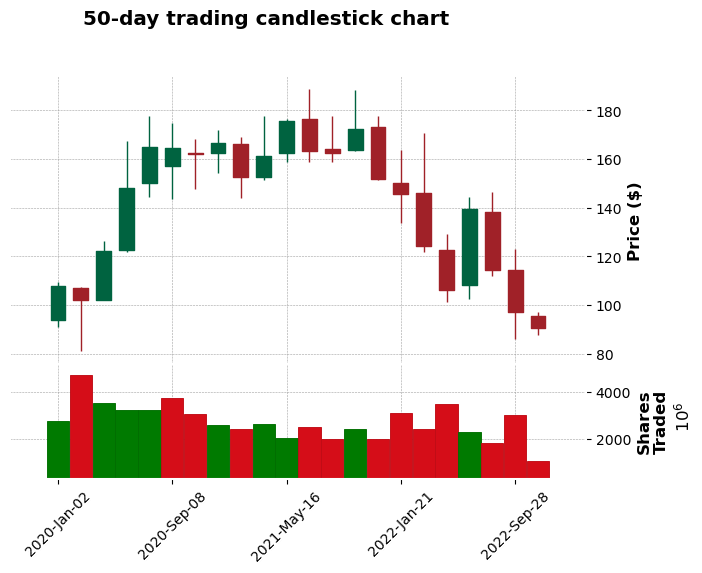

In [40]:
display_stock_candlestick(data["df"], n=50, title='50-day trading candlestick chart')

# Write a function to display stock market financial data using boxplot chart. 
This is particularly useful when you are trying to display your data for a moving window of `n`
consecutive trading days. Again, feel free to use online resources that teach you how to
this but you need to add comments to explain your codes and the parameters you use.

In [41]:
def plot_boxplot_chart(data, n=5, column='close', title='Boxplot Chart', width=0.5, height=6):
    """
    Plots a boxplot chart for the provided stock market depends on column's price data over a moving window of n in consecutive days.
    
    Parameters:
        data: (pd.DataFrame), DataFrame containing stock market data with at least one chosen parameter column and Date index.
        n: int, trading days, require more or equal to 1, default is assigned with =.
        column: str, column name in data, default is assigned with 'close'.
        title: str, title input for boxplot chart, default is assigned with =.
        width: float, width of the boxplot chart, default is assigned with 0.5.
        height: float, height of the boxplot chart, default is assigned with 6.
    """

    # Check if data is a DataFrame
    if not isinstance(data, pd.DataFrame):
        print("Data must be a pandas DataFrame.")
        return
    
    # Check if column is in the DataFrame
    if column not in data.columns:
        print(f"{column} column must contain in the DataFrame.")
        return
    
    # Check if n is an integer greater than or equal to 1
    if n < 1 or not isinstance(n, int):
        print("Parameter 'n' must be an integer greater than or equal to 1.")
        return
    
    # Calculate the total number of windows
    total_windows = len(data) - n + 1 # If n=maximum number of days, total window will display last one
    print (f"data: {len(data)}, n: {n}, total_windows: {total_windows}")
    # len(data): total number of rows
    

    # Raise an error if there are not enough data points for the specified window size
    if total_windows <= 0:
        print("Not enough data points for the specified window size.")
        return

    # Prepare the data for the boxplot chart
    boxplot_data = []
    # Labels for the x-axis
    labels = []

    # Iterate through the data to create the boxplot data
    for i in range(total_windows):
        window_data = data[column].iloc[i:i+n] # Retrieve the data through the window size
        boxplot_data.append(window_data.values) # Append the data to the boxplot data list
        window_date = data.index[i + n - 1].strftime('%Y-%m-%d') # Get the last date of the window date
        labels.append(window_date) # Append the date to the labels list
    
    # Create the subplots with fig(unused) and ax
    fig, ax = plt.subplots()
    # set the boxplot chart wider
    fig.set_size_inches(width, height)
    # Set the box properties, parameters: data, colorise the boxplot, put the plot vertically
    plt.boxplot(boxplot_data, patch_artist=True, vert=True)
    # Set the title of the boxplot chart by passing the parameter title
    ax.set_title(title)
    # Set the x-axis label 
    ax.set_xlabel('Moving Window Dates')
    # Set the y-axis label 
    ax.set_ylabel(f'{column} Price')
    # Set the x-axis ticks with the labels(dates) and rotate the labels
    ax.set_xticklabels(labels, rotation=45)
    
    # Display the boxplot chart
    plt.show()


data: 741, n: 139, total_windows: 603


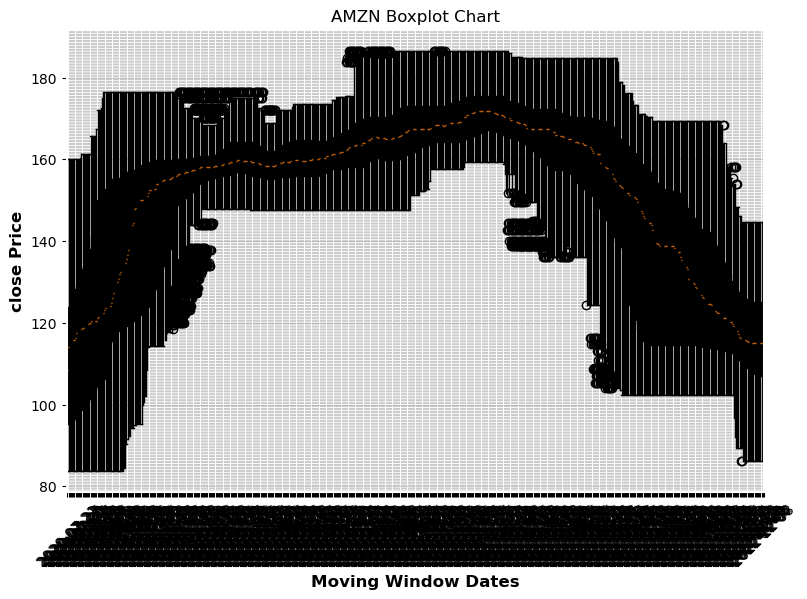

In [42]:
plot_boxplot_chart(data["df"], n=139, column='close', title=f'{TICKER} Boxplot Chart', width=9, height=6)

data: 741, n: 650, total_windows: 92


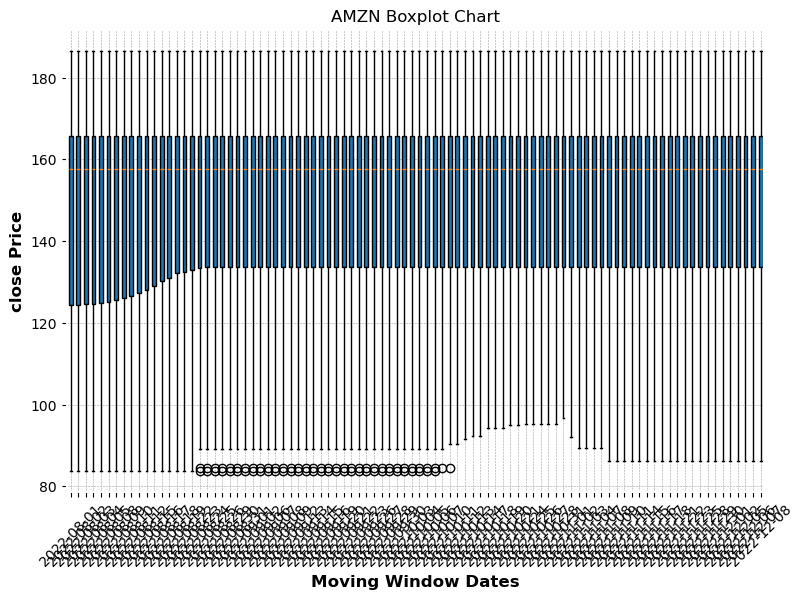

In [43]:
plot_boxplot_chart(data["df"], n=650, column='close', title=f'{TICKER} Boxplot Chart', width=9, height=6)

data: 741, n: 700, total_windows: 42


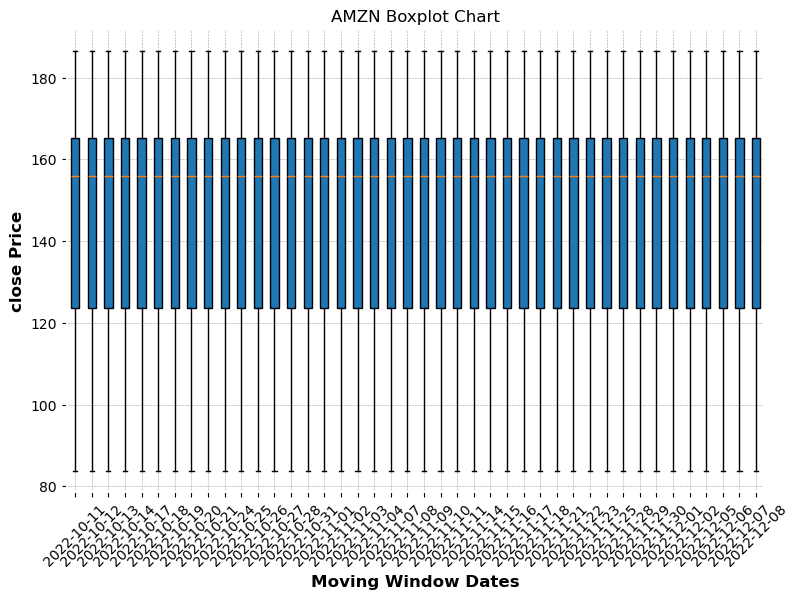

In [44]:
plot_boxplot_chart(data["df"], n=700, column='close', title=f'{TICKER} Boxplot Chart', width=9, height=6)

data: 741, n: 720, total_windows: 22


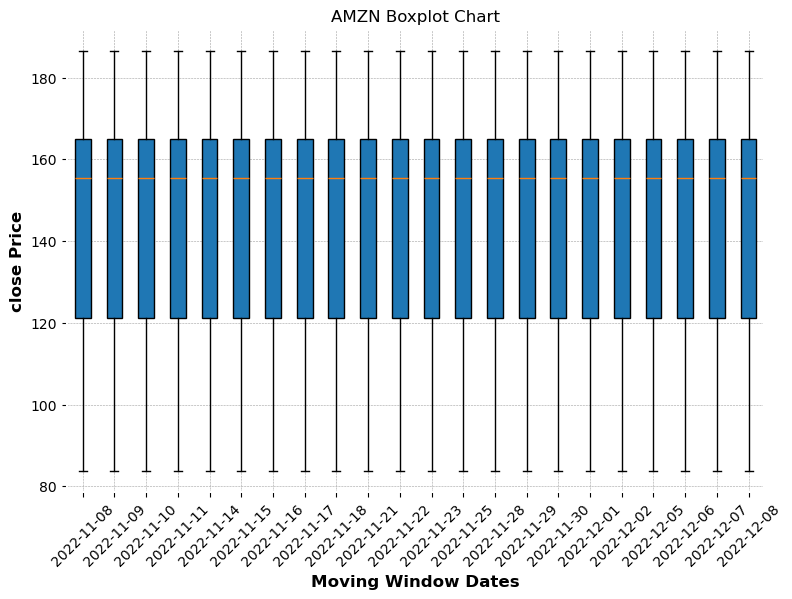

In [45]:
plot_boxplot_chart(data["df"], n=720, column='close', title=f'{TICKER} Boxplot Chart', width=9, height=6)

In [46]:
plot_boxplot_chart(data["df"], n=750, column='close', title=f'{TICKER} Boxplot Chart', width=9, height=6)

data: 741, n: 750, total_windows: -8
Not enough data points for the specified window size.


# v0.3: Machine Learning 1

Write a function that takes as input several parameters including the number of layers, the
size of each layer, the layer name and return a Deep Learning model. 

Again, our reference project (`P1`) will give you an example of how this can be done. 

You can reuse this example, extend it, and most importantly, explain in detail all the code in your program

In [47]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    
    # create the model
    model = Sequential()

    # ilterate through the number of layers to add
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                # add bidirectional LSTM
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                # add simple (name) layer
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                 # add simple (name) layer
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                 # add simple (name) layer
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    # add dense layer with linear activation
    model.add(Dense(1, activation="linear"))
    # compile the model with optimizer, loss, and metrics
    # loss is mean absolute error, good for regression problems
    # the metric is mean absolute error, same as the loss, to see the error
    # optimizer is the default RMS prop: rmsprop means Root Mean Square Propagation
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

Use the above function to experiment with different DL networks (e.g., LSTM, RNN, GRU,
etc.) and with different hyperparameter configurations (e.g. different numbers of layers and
layer sizes, number of epochs, batch sizes, etc.)

In [48]:
# layer name
LAYER_NAME = LSTM

# layer size (number of neurons)
N_SIZE = 256

# number of layers
N_LAYERS = 3

# batch size
BATCH_SIZE = 64

# epochs (number of iterations training the data on the model)
EPOCHS = 100

# show now date with format YYYY-MM-DD
DATE_NOW = time.strftime("%Y-%m-%d")

# loss function
LOSS='huber_loss'

# optimizer with specific algorithm
OPTIMIZER='adam'

# features as always the fundamental features
N_FEATURES = ["adjclose", "volume", "open", "high", "low"]

# whether to use bidirectional RNNs
BIDIRECTIONAL = False

# 40% dropout
DROPOUT = 0.4

# When to shuffle the dataset
shuffle_str = f"sh-{int(SHUFFLE)}"

# When to scale the dataset
scale_str = f"sc-{int(SCALE)}"

# Whether to split the dataset by date
SPLIT_BY_DATE_str = f"sbd-{int(SPLIT_BY_DATE)}"

# save model name, and make it unique as possible
model_name = f"{DATE_NOW}_{TICKER}-{shuffle_str}-{scale_str}-{SPLIT_BY_DATE_str}-{LAYER_NAME.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{N_SIZE}-epoch-{EPOCHS}"

# bidirectional model
if BIDIRECTIONAL:
    model_name += "-b"

In [49]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")

In [50]:
# Check if data["X_train"] is a NumPy array
is_numpy_array = isinstance(data["X_train"], np.ndarray)

# Check if the elements are of type float
if is_numpy_array:
    is_float_type = np.issubdtype(data["X_train"].dtype, np.floating)
    print(f"data['X_train'] is a NumPy array: {is_numpy_array}")
    print(f"data['X_train'] elements are of float type: {is_float_type}")
else:
    print("data['X_train'] is not a NumPy array.")

data['X_train'] is a NumPy array: True
data['X_train'] elements are of float type: True


In [51]:
import shutil

# Delete the contents of the logs directory
shutil.rmtree('logs')

In [52]:
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=N_SIZE, cell=LAYER_NAME, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/100


2024-09-08 13:35:07.759409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-08 13:35:07.759930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-08 13:35:07.760484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - ETA: 0s - loss: 137.2806 - mean_absolute_error: 137.7806

2024-09-08 13:35:12.094638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-08 13:35:12.095306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-08 13:35:12.095751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 127.03374, saving model to results/2024-09-08_AMZN-sh-1-sc-1-sbd-0-LSTM-seq-50-step-15-layers-3-units-256-epoch-100.h5
9/9 [==============================] - 5s 352ms/step - loss: 137.2806 - mean_absolute_error: 137.7806 - val_loss: 127.0337 - val_mean_absolute_error: 127.5337
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 125.5072 - mean_absolute_error: 126.0072
Epoch 2: val_loss improved from 127.03374 to 121.69491, saving model to results/2024-09-08_AMZN-sh-1-sc-1-sbd-0-LSTM-seq-50-step-15-layers-3-units-256-epoch-100.h5
9/9 [==============================] - 3s 336ms/step - loss: 125.5072 - mean_absolute_error: 126.0072 - val_loss: 121.6949 - val_mean_absolute_error: 122.1949
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 121.8635 - mean_absolute_error: 122.3635
Epoch 3: val_loss improved from 121.69491 to 119.07419, saving model to results/2024-09-08_AMZN-sh-1-sc-1-sbd-0-LSTM-seq-50-step-15-layers-3-un

In [53]:
#pip install -r requirements.txt

In [54]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 65178), started 1 day, 19:32:02 ago. (Use '!kill 65178' to kill it.)

In [55]:
EPOCHS = 200

# save model name, and make it unique as possible
model_name = f"{DATE_NOW}_{TICKER}-{shuffle_str}-{scale_str}-{SPLIT_BY_DATE_str}-{LAYER_NAME.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{N_SIZE}-EPOCHS-{EPOCHS}"

In [56]:
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=N_SIZE, cell=LAYER_NAME, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

2024-09-08 13:40:37.137826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-08 13:40:37.138396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-08 13:40:37.138948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/200


2024-09-08 13:40:37.413841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-08 13:40:37.414798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-08 13:40:37.415357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - ETA: 0s - loss: 138.3934 - mean_absolute_error: 138.8934

2024-09-08 13:40:41.702519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-08 13:40:41.703316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-08 13:40:41.704175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 128.88939, saving model to results/2024-09-08_AMZN-sh-1-sc-1-sbd-0-LSTM-seq-50-step-15-layers-3-units-256-EPOCHS-200.h5
9/9 [==============================] - 5s 372ms/step - loss: 138.3934 - mean_absolute_error: 138.8934 - val_loss: 128.8894 - val_mean_absolute_error: 129.3894
Epoch 2/200
9/9 [==============================] - ETA: 0s - loss: 127.3401 - mean_absolute_error: 127.8401
Epoch 2: val_loss improved from 128.88939 to 123.45541, saving model to results/2024-09-08_AMZN-sh-1-sc-1-sbd-0-LSTM-seq-50-step-15-layers-3-units-256-EPOCHS-200.h5
9/9 [==============================] - 3s 388ms/step - loss: 127.3401 - mean_absolute_error: 127.8401 - val_loss: 123.4554 - val_mean_absolute_error: 123.9554
Epoch 3/200
9/9 [==============================] - ETA: 0s - loss: 123.4486 - mean_absolute_error: 123.9486
Epoch 3: val_loss improved from 123.45541 to 120.72736, saving model to results/2024-09-08_AMZN-sh-1-sc-1-sbd-0-LSTM-seq-50-step-15-layers-3-

In [57]:
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 65178), started 1 day, 19:43:05 ago. (Use '!kill 65178' to kill it.)

In [58]:
LAYER_NAME = RNN

# save model name, and make it unique as possible
model_name = f"{DATE_NOW}_{TICKER}-{shuffle_str}-{scale_str}-{SPLIT_BY_DATE_str}-{LAYER_NAME.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{N_SIZE}-EPOCHS-{EPOCHS}"

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/200
9/9 [==============================] - ETA: 0s - loss: 20.3918 - mean_absolute_error: 20.8827
Epoch 1: val_loss improved from inf to 20.67273, saving model to results/2024-09-08_AMZN-sh-1-sc-1-sbd-0-RNN-seq-50-step-15-layers-3-units-256-EPOCHS-200.h5
9/9 [==============================] - 3s 352ms/step - loss: 20.3918 - mean_absolute_error: 20.8827 - val_loss: 20.6727 - val_mean_absolute_error: 21.1706
Epoch 2/200
9/9 [==============================] - ETA: 0s - loss: 20.2753 - mean_absolute_error: 20.7688
Epoch 2: val_loss improved from 20.67273 to 20.66438, saving model to results/2024-09-08_AMZN-sh-1-sc-1-sbd-0-RNN-seq-50-step-15-layers-3-units-256-EPOCHS-200.h5
9/9 [==============================] - 3s 347ms/step - loss: 20.2753 - mean_absolute_error: 20.7688 - val_loss: 20.6644 - val_mean_absolute_error: 21.1616
Epoch 3/200
9/9 [==============================] - ETA: 0s - loss: 20.3020 - mean_absolute_error: 20.7972
Epoch 3: val_loss did not improve from 20.66438
9/9 [

In [59]:
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 65178), started 1 day, 19:54:48 ago. (Use '!kill 65178' to kill it.)

In [60]:
LAYER_NAME = GRU

# save model name, and make it unique as possible
model_name = f"{DATE_NOW}_{TICKER}-{shuffle_str}-{scale_str}-{SPLIT_BY_DATE_str}-{LAYER_NAME.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{N_SIZE}-EPOCHS-{EPOCHS}"

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/200
9/9 [==============================] - ETA: 0s - loss: 20.1812 - mean_absolute_error: 20.6723
Epoch 1: val_loss improved from inf to 20.65155, saving model to results/2024-09-08_AMZN-sh-1-sc-1-sbd-0-GRU-seq-50-step-15-layers-3-units-256-EPOCHS-200.h5
9/9 [==============================] - 4s 464ms/step - loss: 20.1812 - mean_absolute_error: 20.6723 - val_loss: 20.6516 - val_mean_absolute_error: 21.1477
Epoch 2/200
9/9 [==============================] - ETA: 0s - loss: 20.5882 - mean_absolute_error: 21.0793
Epoch 2: val_loss did not improve from 20.65155
9/9 [==============================] - 3s 361ms/step - loss: 20.5882 - mean_absolute_error: 21.0793 - val_loss: 20.6750 - val_mean_absolute_error: 21.1730
Epoch 3/200
9/9 [==============================] - ETA: 0s - loss: 20.3173 - mean_absolute_error: 20.8103
Epoch 3: val_loss did not improve from 20.65155
9/9 [==============================] - 3s 359ms/step - loss: 20.3173 - mean_absolute_error: 20.8103 - val_loss: 20.9383

In [61]:
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 65178), started 1 day, 20:05:38 ago. (Use '!kill 65178' to kill it.)

In [62]:
# layer size
N_SIZE = 128

# construct the model
model_name = f"{DATE_NOW}_{TICKER}-{shuffle_str}-{scale_str}-{SPLIT_BY_DATE_str}-{LAYER_NAME.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{N_SIZE}-EPOCHS-{EPOCHS}"

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/200
9/9 [==============================] - ETA: 0s - loss: 20.0488 - mean_absolute_error: 20.5422
Epoch 1: val_loss improved from inf to 20.66061, saving model to results/2024-09-08_AMZN-sh-1-sc-1-sbd-0-GRU-seq-50-step-15-layers-3-units-128-EPOCHS-200.h5
9/9 [==============================] - 3s 375ms/step - loss: 20.0488 - mean_absolute_error: 20.5422 - val_loss: 20.6606 - val_mean_absolute_error: 21.1575
Epoch 2/200
9/9 [==============================] - ETA: 0s - loss: 20.4981 - mean_absolute_error: 20.9915
Epoch 2: val_loss did not improve from 20.66061
9/9 [==============================] - 3s 350ms/step - loss: 20.4981 - mean_absolute_error: 20.9915 - val_loss: 20.7158 - val_mean_absolute_error: 21.2155
Epoch 3/200
9/9 [==============================] - ETA: 0s - loss: 20.7176 - mean_absolute_error: 21.2119
Epoch 3: val_loss did not improve from 20.66061
9/9 [==============================] - 3s 356ms/step - loss: 20.7176 - mean_absolute_error: 21.2119 - val_loss: 20.7485

In [63]:
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 65178), started 1 day, 20:16:22 ago. (Use '!kill 65178' to kill it.)

In [64]:
# Number of batch size
BATCH_SIZE = 32

# construct the model
model_name = f"{DATE_NOW}_{TICKER}-{shuffle_str}-{scale_str}-{SPLIT_BY_DATE_str}-{LAYER_NAME.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{N_SIZE}-EPOCHS-{EPOCHS}-batch-{BATCH_SIZE}"

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/200
18/18 [==============================] - ETA: 0s - loss: 20.1756 - mean_absolute_error: 20.6656
Epoch 1: val_loss improved from inf to 20.70177, saving model to results/2024-09-08_AMZN-sh-1-sc-1-sbd-0-GRU-seq-50-step-15-layers-3-units-128-EPOCHS-200-batch-32.h5
18/18 [==============================] - 5s 250ms/step - loss: 20.1756 - mean_absolute_error: 20.6656 - val_loss: 20.7018 - val_mean_absolute_error: 21.2011
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 20.3977 - mean_absolute_error: 20.8904
Epoch 2: val_loss did not improve from 20.70177
18/18 [==============================] - 4s 242ms/step - loss: 20.3977 - mean_absolute_error: 20.8904 - val_loss: 20.7628 - val_mean_absolute_error: 21.2626
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 20.1449 - mean_absolute_error: 20.6388
Epoch 3: val_loss did not improve from 20.70177
18/18 [==============================] - 5s 251ms/step - loss: 20.1449 - mean_absolute_error: 20.638

In [65]:
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 65178), started 1 day, 20:29:57 ago. (Use '!kill 65178' to kill it.)